In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
#from plotting import annotate_corr
#from matplotlib.lines import Line2D
#from functools import partial
#from scipy import stats

sns.set(style='ticks', context='paper',
        rc={'font.size': 6, 
            'axes.titlesize': 7,
            'axes.labelsize': 7,
            'axes.labelpad': 2,
            'xtick.labelsize': 5,
            'ytick.labelsize': 5,
            'legend.title_fontsize' : 5.5,
            'legend.fontsize' : 5.5,
            'legend.markerscale': 0.5,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'axes.linewidth': 0.4,
            'xtick.major.width': 0.4,
            'ytick.major.width': 0.4,
            'xtick.major.size': 2.5,
            'ytick.major.size': 2.5,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.minor.width': 0.2,
            'ytick.minor.width': 0.2,
            'figure.constrained_layout.use': True,
            'figure.dpi': 200})

#id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}



In [1]:
#p1 = '/home/wtownle1/dimensionality_powerlaw/activation_models/AtlasNet/'
#p2 = '/home/wtownle1/dimensionality_powerlaw/activation_models/'
p3 = '/home/wtownle1/dimensionality_powerlaw/'
import sys
#sys.path.append(p1)
#sys.path.append(p2)
sys.path.append(p3)
from activation_models.AtlasNet.model_2L_eig import EngineeredModel2L_Eig
from activation_models.AtlasNet.model_2L import EngineeredModel2L
from torch import nn

weight_dict = {}
#alphas = [-0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0, -1.2, -1.4, -1.6, -1.8, -2, -2.2, -2.4, -2.6, -2.8, -3]
alphas = [-0.6, -1, -1.4, 'none']
for a in alphas:
    if a == 'none':
        model = EngineeredModel2L(filters_2=1000, k_size=9, seed=0).Build()
    else:
        model = EngineeredModel2L_Eig(filters_2=1000, k_size=9, exponent=a, seed=0).Build()

    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            weight_dict[a] = m.weight

0.6400838939930912
0.010508162771130496
1.0552014868159694
0.010077028850817148
1.479745406977441
0.010028993692880885


In [2]:
from sklearn.decomposition import PCA
from model_tools.activations.core import flatten
import numpy as np

eigenspectrum = {}
for alpha, weights in weight_dict.items():
    weights = weights.numpy(force=True)
    weights = flatten(weights)
    pca = PCA(random_state=0)
    pca.fit(weights)
    eigenspectrum[alpha] = pca.explained_variance_


In [5]:
def effective_dimensionalities(eigenspectrum):
    effdims = {alpha: eigspec.sum() ** 2 / (eigspec ** 2).sum()
                for alpha, eigspec in eigenspectrum.items()}
    return effdims

def powerlaw_exponent(eigenspectrum):
    alpha_calculated = {}
    for alpha, eigspec in eigenspectrum.items():
        start = 0
        end = np.log10(len(eigspec))
        eignum = np.logspace(start, end, num=50).round().astype(int)
        eigspec = eigspec[eignum - 1]
        logeignum = np.log10(eignum)
        logeigspec = np.log10(eigspec)
        linear_fit = LinearRegression().fit(logeignum.reshape(-1, 1), logeigspec)
        alpha_calculated[alpha] = -linear_fit.coef_.item()
    return alpha_calculated


def as_df(eigenspectrum):
    df = pd.DataFrame()
    for alpha, rdm in eigenspectrum.items():
        layer_df = pd.DataFrame({'n': range(1, len(rdm) + 1), 'variance': rdm})
        layer_df = layer_df.assign(specified_alpha=alpha)
        df = df.append(layer_df)
    return df

def metrics_as_df(eigenspectrum):
    effdims = effective_dimensionalities(eigenspectrum)
    calculated_alpha = powerlaw_exponent(eigenspectrum)
    df = pd.DataFrame()
    for alpha in eigenspectrum:
        df = df.append({'specified_alpha': alpha,
                        'effective dimensionality': effdims[alpha],
                        'calculated_alpha': calculated_alpha[alpha]},
                        ignore_index=True)
    return df


In [6]:
import pandas as pd
from sklearn.linear_model import LinearRegression

eigspec_df = pd.DataFrame()
eigmetrics_df = pd.DataFrame()

eigspec_df = eigspec_df.append(as_df(eigenspectrum))
eigmetrics_df = eigmetrics_df.append(metrics_as_df(eigenspectrum))

#eigspec_df.to_csv(f'/home/wtownle1/dimensionality_powerlaw/results/weight_spectrum/weightspectra_AtlasNet_Eig|seed:0.csv', index=False)
#eigmetrics_df.to_csv(f'/home/wtownle1/dimensionality_powerlaw/results/weight_spectrum/weightmetrics_AtlasNet_Eig|seed:0.csv', index=False)



In [11]:
print(eigmetrics_df)

  specified_alpha  effective dimensionality  calculated_alpha
0            -0.6                357.857951          1.041699
1            -1.0                 38.757505          1.383087
2            -1.4                  7.001104          1.774377
3            none                659.963665          0.700317


/home/wtownle1/.conda/envs/dim-powerlaw/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.


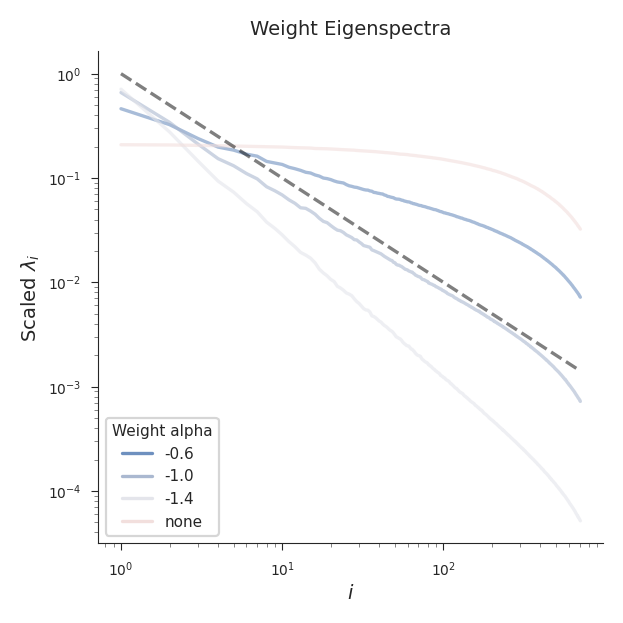

In [12]:

#metrics = pd.read_csv(f'../../results/weight_spectrum/weightmetrics_AtlasNet_Eig|seed:0.csv')
#spectra = pd.read_csv(f'../../results/weight_spectrum/weightspectra_AtlasNet_Eig|seed:0.csv')

id_columns = ['specified_alpha']
#data = pd.merge(spectra, metrics, on=id_columns)
data = pd.merge(eigspec_df, eigmetrics_df, on=id_columns)
#data['id'] = 'AtlasNet|alpha='
data.replace('none', 20)

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = round(np.log10(data['effective dimensionality']), 2)

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='specified_alpha',
             units='specified_alpha', alpha=0.6, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=False), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Weight Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'Weight alpha')
plt.show()


#keep = 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 2
#data = data[( data['specified_alpha'] != -0.2)]
#data = data[( data['specified_alpha'] != -0.3)]
#data = data[( data['specified_alpha'] != -0.5)]
#data = data[( data['specified_alpha'] != -0.7)]
#data = data[( data['specified_alpha'] != -0.9)]
#data = data[( data['specified_alpha'] != -1.8)]
#data = data[( data['specified_alpha'] != -2.2)]
#data = data[( data['specified_alpha'] != -2.4)]
#data = data[( data['specified_alpha'] != -2.6)]
#data = data[( data['specified_alpha'] != -2.8)]
#data = data[( data['specified_alpha'] != -3)]
#fig, ax = plt.subplots(figsize=(3, 3))
#sns.lineplot(data=data, x='n', y='scaled_variance', hue='specified_alpha',
#             units='specified_alpha', alpha=1, estimator=None,
#             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
#ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
#ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Eigenspectra')
##ax.set_ylim(bottom=10**(-9), top=10**4)
#ax.get_legend().remove()
##**ylimits?
#plt.show()

In [10]:
from torchvision.models import alexnet
from torch import nn

weight_string = 'IMAGENET1K_V1'
model = alexnet(weights=weight_string)

weight_dict = {}
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d):
        weight_dict[name] = module.weight


In [4]:
from sklearn.decomposition import PCA
from model_tools.activations.core import flatten
#import numpy as np

eigenspectrum = {}
for layer, weights in weight_dict.items():
    weights = weights.numpy(force=True)
    weights = flatten(weights)
    pca = PCA(random_state=0)
    pca.fit(weights)
    eigenspectrum[layer] = pca.explained_variance_


In [5]:
def effective_dimensionalities(eigenspectrum):
    effdims = {layer: eigspec.sum() ** 2 / (eigspec ** 2).sum()
                for layer, eigspec in eigenspectrum.items()}
    return effdims

def powerlaw_exponent(eigenspectrum):
    alpha_calculated = {}
    for layer, eigspec in eigenspectrum.items():
        start = 0
        end = np.log10(len(eigspec))
        eignum = np.logspace(start, end, num=50).round().astype(int)
        eigspec = eigspec[eignum - 1]
        logeignum = np.log10(eignum)
        logeigspec = np.log10(eigspec)
        linear_fit = LinearRegression().fit(logeignum.reshape(-1, 1), logeigspec)
        alpha_calculated[layer] = -linear_fit.coef_.item()
    return alpha_calculated


def as_df(eigenspectrum):
    df = pd.DataFrame()
    for layer, rdm in eigenspectrum.items():
        layer_df = pd.DataFrame({'n': range(1, len(rdm) + 1), 'variance': rdm})
        layer_df = layer_df.assign(layer=layer)
        df = df.append(layer_df)
    return df

def metrics_as_df(eigenspectrum):
    effdims = effective_dimensionalities(eigenspectrum)
    calculated_alpha = powerlaw_exponent(eigenspectrum)
    df = pd.DataFrame()
    for layer in eigenspectrum:
        df = df.append({'layer': layer,
                        'effective dimensionality': effdims[layer],
                        'alpha': calculated_alpha[layer]},
                        ignore_index=True)
    return df


In [12]:
import pandas as pd
from sklearn.linear_model import LinearRegression

eigspec_df = pd.DataFrame()
eigmetrics_df = pd.DataFrame()

eigspec_df = eigspec_df.append(as_df(eigenspectrum))
eigmetrics_df = eigmetrics_df.append(metrics_as_df(eigenspectrum))
#print(eigmetrics_df)

eigspec_df.to_csv(f'/home/wtownle1/dimensionality_powerlaw/results/weight_spectrum/weightspectra_AlexNet|weights:{weight_string}.csv', index=False)
eigmetrics_df.to_csv(f'/home/wtownle1/dimensionality_powerlaw/results/weight_spectrum/weightmetrics_AlexNet|weights:{weight_string}.csv', index=False)



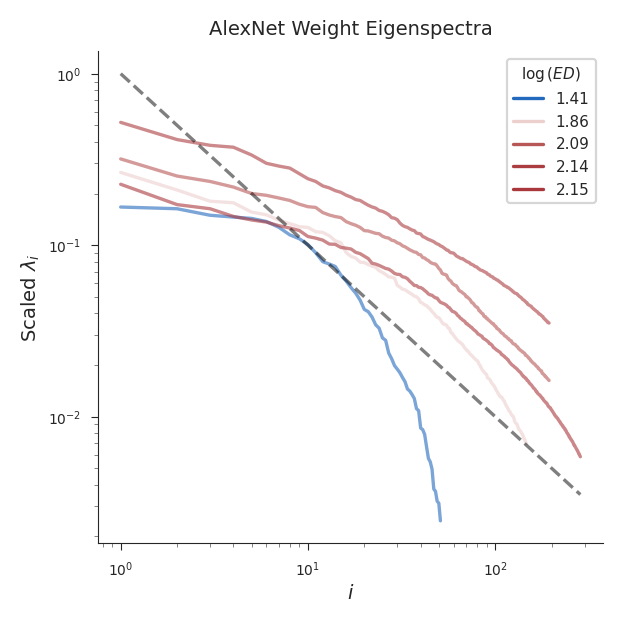

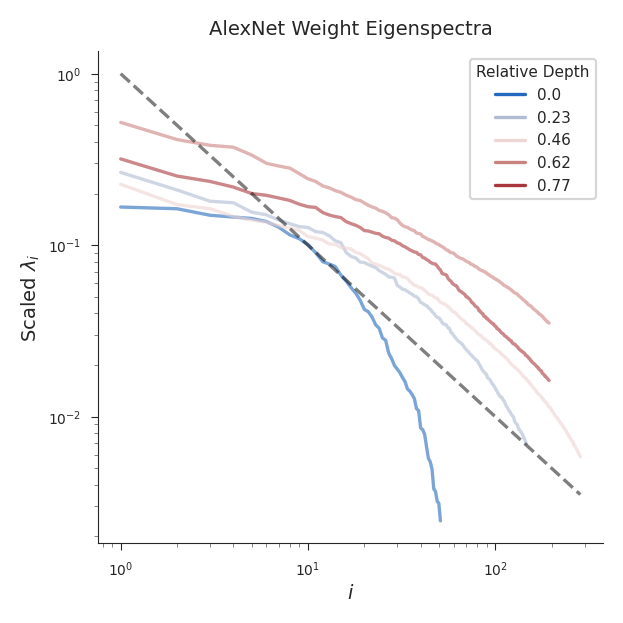

In [17]:
#metrics = pd.read_csv(f'../../results/weight_spectrum/weightmetrics_AlexNet|weights:IMAGENET1K_V1.csv')
#spectra = pd.read_csv(f'../../results/weight_spectrum/weightspectra_AlexNet|weights:IMAGENET1K_V1.csv')

id_columns = ['layer']
data = pd.merge(eigspec_df, eigmetrics_df, on=id_columns)
#data['id'] = 'AtlasNet|alpha='

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = round(np.log10(data['effective dimensionality']), 2)

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='layer', alpha=0.6, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='AlexNet Weight Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'$\log{(ED)}$')
plt.show()


#Relative depth
model_depth = 13
layer_depth = round( data['layer'].str.split(pat='.').str[1].astype(float) / model_depth, 2)
data['layer_depth'] = layer_depth

fig, ax = plt.subplots(figsize=(3, 3))
sns.lineplot(data=data, x='n', y='scaled_variance', hue='layer_depth', legend='full',
             units='layer', alpha=0.6, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='AlexNet Weight Eigenspectra')
#ax.set_ylim(bottom=10**(-9), top=10**4)
#**ylimits?
ax.legend(title=r'Relative Depth')
plt.show()

